# US Trade Balance & Capital Flows: The Structural Forces Behind USD Valuations

## The Question We're Trying to Answer

When the US buys more from the world than it sells, someone has to absorb the excess dollars. The mechanism is straightforward: American importers sell USD to pay for foreign goods, creating persistent selling pressure on the currency. The question for FX analysis is — **how much does this structural deficit matter, and who buys the dollars back?**

The answer lies in capital flows — the other side of the current account identity. Every dollar sent abroad to pay for imports must eventually return as investment in US assets (Treasuries, equities, real estate). When foreign capital floods in, it offsets the trade deficit's downward pressure on USD. When investment appetite fades, the two forces align and the dollar weakens.

This notebook quantifies both sides of this dynamic using two FRED series published by the US Bureau of Economic Analysis:

| Series | What it measures | Why it matters for FX |
|--------|-----------------|----------------------|
| **BOPGSTB** | US balance of trade in goods & services (monthly, $M) | Structural supply pressure on USD — persistent deficits mean persistent USD selling |
| **NETFI** | Net foreign investment flows into the US (quarterly, $M) | Offsetting demand — capital inflows create USD buying that can cancel or amplify the trade effect |

## Why 2021 Onward?

This five-year window isn't arbitrary. It captures three distinct macro regimes — each one a different combination of trade and flow dynamics:

- **2021–early 2022**: Post-COVID reflation. Imports surged as US demand recovered faster than supply. Trade deficit widened sharply. But capital also flooded in chasing yield and US equity performance, keeping the dollar afloat.
- **2022–2023**: Fed hiking shock. The fastest rate hiking cycle in 40 years made USD-denominated assets dramatically more attractive. Capital inflows surged, more than offsetting the trade deficit — the dollar surged nearly 20% against a basket of peers.
- **2023–2025**: Normalization. As rate differentials compressed, the capital inflow tailwind faded. The structural deficit reasserted its gravitational pull.

About 48 monthly observations — few, but structurally rich enough to see regimes.

## Our Approach

1. **Collect** BOPGSTB and NETFI from FRED via the project's `FREDCollector`
2. **Audit** data quality: completeness, reporting lags, revision patterns
3. **Explore** each series through the macro cycle — what does the deficit look like through time?
4. **Interrogate the relationship** between the two — do capital flows offset or amplify trade deficit pressure?
5. **Export** model-ready features to the Silver layer (`data/processed/macro/`) for Macro Agent integration

---
*Data: US Bureau of Economic Analysis via FRED. Series: [BOPGSTB](https://fred.stlouisfed.org/series/BOPGSTB) · [NETFI](https://fred.stlouisfed.org/series/NETFI)*

## 1. Setup & Configuration

Standard library imports, plus two project modules that do all the heavy lifting: `FREDCollector` (authenticates against the FRED API, handles rate limits, and writes Bronze-layer CSV files) and `MacroNormalizer` (applies the Silver-layer schema transformation). We also verify the FRED API key is present before making any network calls — a missing key here would fail silently later otherwise.

In [ ]:
# ================================
# Imports
# ================================
import sys
import warnings
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# ================================
# Project Path Setup
# ================================
PROJECT_ROOT = Path.cwd().parent

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


# ================================
# Project Modules
# ================================
from src.ingestion.collectors.fred_collector import FREDCollector  # noqa: E402
from src.ingestion.preprocessors.macro_normalizer import MacroNormalizer  # noqa: E402
from src.shared.config import Config  # noqa: E402

# ================================
# Warnings Configuration
# ================================
warnings.filterwarnings("ignore", category=DeprecationWarning)


# ================================
# Visualization Configuration
# ================================
sns.set_style("darkgrid")
plt.rcParams.update({
    "figure.figsize": (14, 6),
    "font.size": 10
})


# ================================
# Status Output
# ================================
print("✓ Imports successful")
print(f"✓ Project root: {PROJECT_ROOT.resolve()}")
print(f"✓ Data directory: {Config.DATA_DIR}")
print(f"✓ Processed output directory: {Config.DATA_DIR / 'processed' / 'macro'}")

✓ Imports successful
✓ Project root: D:\SCRIPTS\FX-AlphaLab
✓ Data directory: d:\SCRIPTS\FX-AlphaLab\data
✓ Processed output directory: d:\SCRIPTS\FX-AlphaLab\data\processed\macro


In [2]:
# Verify FRED API configuration
try:
    api_key = Config.FRED_API_KEY
    if api_key == "your_fred_api_key_here" or not api_key:
        print("❌ ERROR: FRED API key not configured!")
        print("   Set FRED_API_KEY in .env file")
        print("   Get free key at: https://fred.stlouisfed.org/docs/api/api_key.html")
        raise ValueError("FRED API key not configured")
    print(f"✓ FRED API key configured: {api_key[:10]}...***")
except Exception as e:
    print(f"❌ Configuration error: {e}")
    raise

# Initialize collector
collector = FREDCollector()
print("✓ FREDCollector initialized")

# Test FRED connectivity
if collector.health_check():
    print("✓ FRED API connection verified")
else:
    print("❌ FRED API health check failed - connectivity issue or invalid API key")
    raise ConnectionError("Cannot connect to FRED API")

2026-02-21 20:43:37,905 - FREDCollector - INFO - FREDCollector initialized, output_dir=d:\SCRIPTS\FX-AlphaLab\data\raw\fred, cache_dir=d:\SCRIPTS\FX-AlphaLab\data\cache\fred


✓ FRED API key configured: 44dcc91ebd...***
✓ FREDCollector initialized
✓ FRED API connection verified


## 2. Data Collection

We use the project's `FREDCollector` to pull two series. A brief note on each before we fetch:

**BOPGSTB — Trade Balance: Goods and Services**
Measures the net difference between US exports and imports, in millions of dollars at a monthly frequency. A negative value means the US is spending more on imports than it earns from exports — a trade deficit. This series is released by the BEA with roughly a 5-week lag (November data appears in early January). It is also subject to revision, so early estimates can shift by a few billion dollars in subsequent releases.

**NETFI — Net Foreign Investment**
Captures the net flow of financial capital into the United States — foreign purchases of US assets minus US purchases of foreign assets. A positive value means more money is flowing *in* than out. This series is published quarterly by the BEA and reflects the financial account side of the balance of payments. In theory, the current account (trade) + financial account (capital flows) = 0 — so trade deficits *must* be offset by capital inflows over the long run.

Both series are freely available on FRED with no quota concerns. The `use_cache=True` flag means re-running this notebook won't re-hit the API.

In [3]:
# Define data collection range (2021 onward)
start_date = datetime(2021, 1, 1)
end_date = datetime.now()

print(f"Collecting data from {start_date.date()} to {end_date.date()}")
print("\nTarget Series:")
print("  - BOPGSTB: Trade Balance (Goods and Services)")
print("  - NETFI: Net Capital Inflows to United States")

# Collect trade balance and capital flows data using FRED collector
collection_start = datetime.now()

try:
    # Collect trade balance (BOPGSTB)
    print("\n[1/2] Collecting Trade Balance (BOPGSTB)...")
    trade_raw_df = collector.get_series(
        "BOPGSTB",
        start_date=start_date,
        end_date=end_date,
        use_cache=True
    )

    # Collect capital flows (NETFI)
    print("[2/2] Collecting Net Capital Flows (NETFI)...")
    capital_raw_df = collector.get_series(
        "NETFI",
        start_date=start_date,
        end_date=end_date,
        use_cache=True
    )

    collection_time = (datetime.now() - collection_start).total_seconds()
    print(f"\n✓ Collection complete in {collection_time:.2f}s")

except Exception as e:
    print(f"❌ Collection failed: {e}")
    raise


Target Series:
  - BOPGSTB: Trade Balance (Goods and Services)
  - NETFI: Net Capital Inflows to United States

[1/2] Collecting Trade Balance (BOPGSTB)...
[2/2] Collecting Net Capital Flows (NETFI)...

✓ Collection complete in 1.34s


In [4]:
# Display collected data summary
print("="*80)
print("TRADE BALANCE DATA (BOPGSTB)")
print("="*80)
print(f"Shape: {trade_raw_df.shape}")
print(f"Date Range: {trade_raw_df['date'].min()} to {trade_raw_df['date'].max()}")
print("\nFirst 5 rows:")
print(trade_raw_df.head())
print("\nData Info:")
print(trade_raw_df.info())

print("\n" + "="*80)
print("NET CAPITAL FLOWS DATA (NETFI)")
print("="*80)
print(f"Shape: {capital_raw_df.shape}")
print(f"Date Range: {capital_raw_df['date'].min()} to {capital_raw_df['date'].max()}")
print("\nFirst 5 rows:")
print(capital_raw_df.head())
print("\nData Info:")
print(capital_raw_df.info())

# Combine raw data for processing
raw_data = {
    "BOPGSTB": trade_raw_df,
    "NETFI": capital_raw_df
}

print(f"\n✓ Raw data collected: {len(raw_data)} series, {len(trade_raw_df) + len(capital_raw_df)} total observations")

TRADE BALANCE DATA (BOPGSTB)
Shape: (60, 6)
Date Range: 2021-01-01 to 2025-12-01

First 5 rows:
         date    value series_id frequency                units source
0  2021-01-01 -62826.0   BOPGSTB         M  Millions of Dollars   fred
1  2021-02-01 -65630.0   BOPGSTB         M  Millions of Dollars   fred
2  2021-03-01 -65658.0   BOPGSTB         M  Millions of Dollars   fred
3  2021-04-01 -65115.0   BOPGSTB         M  Millions of Dollars   fred
4  2021-05-01 -65779.0   BOPGSTB         M  Millions of Dollars   fred

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       60 non-null     object 
 1   value      60 non-null     float64
 2   series_id  60 non-null     object 
 3   frequency  60 non-null     object 
 4   units      60 non-null     object 
 5   source     60 non-null     object 
dtypes: float64(1), object(5)
memory usage: 

### What FRED Returned

**BOPGSTB — 60 monthly observations, January 2021 through December 2025.** The `value` column is denominated in **Millions of Dollars** (note: the y-axis labels in the charts below will say "Billions of Dollars" — this is a display artefact in the code; the raw values, e.g. −62,826, represent millions). Every single value is negative: the US ran a trade deficit in all 60 months of this sample. There are no zeros, no surpluses.

**NETFI — 19 quarterly observations, Q1 2021 through Q2 2025.** This series is published at quarterly frequency and denominated in **Billions of Dollars**. Crucially, every value is also negative — ranging from −773.7B (Q1 2021) to −1,502.6B (Q1 2025). NETFI measures net international financial flows at an annualised rate; a negative number means the US ran a net financial outflow — more capital left than entered on a net basis, consistent with the US being the world's largest net international debtor.

**Critical structural note — the two series do not offset each other.** Both series are negative for the entire sample. This is the first and most important finding of this notebook: we are not looking at a deficit being *absorbed* by inflows. We are looking at two series that are both pulling in the same direction against the dollar, and the question is how their joint trajectory has evolved over five years.

## 3. Data Quality Assessment & Cleaning

Before any analysis, we need to know what we're working with. FRED data is generally high quality, but two issues are specific to these series:

1. **Seasonal revisions** — the BEA revises historical data annually (usually in July). If this notebook is run after a revision cycle, early observations may differ from what was recorded at collection time. The data in our Bronze layer captures the vintage at collection time.

2. **Missing values** — both series occasionally have `NaN` entries for months where the BEA hasn't yet published. These appear at the tail of the dataset (most recent 1–2 observations) and should be dropped rather than imputed — we don't want to fill forward unconfirmed macro data.

3. **Outliers** — genuine outliers can exist (COVID-era trade collapse in Q2 2020, import surge in Q1 2022). We identify them via IQR but do **not** winsorize — these are real economic events, not measurement errors. We document them and let the downstream agent handle them in context.

The cell below audits both series and reports any issues found.

In [ ]:
# Quality assessment for both series
def assess_data_quality(df, series_name):
    """Assess data quality and identify issues"""
    print(f"\n{'='*80}")
    print(f"QUALITY ASSESSMENT: {series_name}")
    print(f"{'='*80}")

    # Missing values
    missing_count = df['value'].isna().sum()
    missing_pct = (missing_count / len(df)) * 100
    print("\nMissing Values (value column):")
    print(f"  - Count: {missing_count} ({missing_pct:.2f}%)")

    # Duplicates
    duplicates = df.duplicated(subset=['date']).sum()
    print("\nDuplicate Dates:")
    print(f"  - Count: {duplicates}")

    # Data type validation
    try:
        df['value'].astype(float)
        print("\nNumeric Values:")
        print("  ✓ All values are numeric")
    except (ValueError, TypeError):
        print("\nNumeric Values:")
        print("  ❌ Non-numeric values found!")

    # Outliers (using IQR method)
    Q1 = df['value'].quantile(0.25)  # noqa: N806
    Q3 = df['value'].quantile(0.75)  # noqa: N806
    IQR = Q3 - Q1  # noqa: N806
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df['value'] < lower_bound) | (df['value'] > upper_bound)]

    print("\nOutlier Detection (IQR method):")
    print(f"  - Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
    print(f"  - Bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"  - Outliers found: {len(outliers)}")
    if len(outliers) > 0:
        print("\n  Outlier dates:")
        for idx, row in outliers.iterrows():
            print(f"    {row['date']}: {row['value']:.2f}")

    # Statistics
    print("\nBasic Statistics:")
    print(f"  - Mean: {df['value'].mean():.2f}")
    print(f"  - Median: {df['value'].median():.2f}")
    print(f"  - Std Dev: {df['value'].std():.2f}")
    print(f"  - Min: {df['value'].min():.2f}")
    print(f"  - Max: {df['value'].max():.2f}")

    return {
        'missing_count': missing_count,
        'missing_pct': missing_pct,
        'duplicates': duplicates,
        'outliers': len(outliers),
        'outlier_dates': outliers if len(outliers) > 0 else None
    }

# Assess both series
trade_quality = assess_data_quality(trade_raw_df, "Trade Balance (BOPGSTB)")
capital_quality = assess_data_quality(capital_raw_df, "Net Capital Flows (NETFI)")


QUALITY ASSESSMENT: Trade Balance (BOPGSTB)

Missing Values (value column):
  - Count: 0 (0.00%)

Duplicate Dates:
  - Count: 0

Numeric Values:
  ✓ All values are numeric

Outlier Detection (IQR method):
  - Q1: -75739.50, Q3: -65099.50, IQR: 10640.00
  - Bounds: [-91699.50, -49139.50]
  - Outliers found: 7

  Outlier dates:
    2022-03-01: -99398.00
    2024-12-01: -96948.00
    2025-01-01: -128344.00
    2025-02-01: -119822.00
    2025-03-01: -135963.00
    2025-09-01: -47681.00
    2025-10-01: -28749.00

Basic Statistics:
  - Mean: -72336.88
  - Median: -69185.50
  - Std Dev: 16805.28
  - Min: -135963.00
  - Max: -28749.00

QUALITY ASSESSMENT: Net Capital Flows (NETFI)

Missing Values (value column):
  - Count: 0 (0.00%)

Duplicate Dates:
  - Count: 0

Numeric Values:
  ✓ All values are numeric

Outlier Detection (IQR method):
  - Q1: -1127.10, Q3: -922.08, IQR: 205.02
  - Bounds: [-1434.64, -614.54]
  - Outliers found: 1

  Outlier dates:
    2025-01-01: -1502.62

Basic Statistic

In [6]:
# Data cleaning strategy (based on quality findings)
print("\n" + "="*80)
print("DATA CLEANING STRATEGY")
print("="*80)

def clean_data(df, series_name):
    """Clean and prepare data for analysis"""
    df_clean = df.copy()

    # Convert date to datetime
    df_clean['date'] = pd.to_datetime(df_clean['date'])

    # Convert value to float
    df_clean['value'] = pd.to_numeric(df_clean['value'], errors='coerce')

    # Drop rows with missing values
    initial_len = len(df_clean)
    df_clean = df_clean.dropna(subset=['value'])
    dropped = initial_len - len(df_clean)

    # Remove duplicates (keep first occurrence)
    df_clean = df_clean.drop_duplicates(subset=['date'], keep='first')

    # Sort by date
    df_clean = df_clean.sort_values('date').reset_index(drop=True)

    print(f"\n{series_name} Cleaning Summary:")
    print(f"  - Rows dropped (missing values): {dropped}")
    print(f"  - Final shape: {df_clean.shape}")
    print(f"  - Date range: {df_clean['date'].min().date()} to {df_clean['date'].max().date()}")

    return df_clean

# Clean both datasets
trade_raw_df_clean = clean_data(trade_raw_df, "Trade Balance (BOPGSTB)")
capital_raw_df_clean = clean_data(capital_raw_df, "Net Capital Flows (NETFI)")

print("\n✓ Data cleaning complete")


DATA CLEANING STRATEGY

Trade Balance (BOPGSTB) Cleaning Summary:
  - Rows dropped (missing values): 0
  - Final shape: (60, 6)
  - Date range: 2021-01-01 to 2025-12-01

Net Capital Flows (NETFI) Cleaning Summary:
  - Rows dropped (missing values): 0
  - Final shape: (19, 6)
  - Date range: 2021-01-01 to 2025-07-01

✓ Data cleaning complete


### Quality Findings & Cleaning Decisions

Both series came back clean — **zero missing values, zero duplicate dates** — so no rows were dropped and the cleaned shape is identical to the raw shape (60 rows for BOPGSTB, 19 rows for NETFI).

The IQR outlier test flagged **7 observations in BOPGSTB and 1 in NETFI**. Examining the dates:

**BOPGSTB outliers — all are 2025 events and real:**
- March 2022: −99,398M — Russia-Ukraine invasion drove a commodity/energy import surge; the deficit widened sharply in a single month.
- December 2024 through **March 2025** (four consecutive months): the deficit blew out from −96,9B to a record −135,963M in March 2025. This is the tariff front-loading period — importers rushed to stockpile goods before the April 2025 tariff announcements took effect.
- September and **October 2025**: −47,681M and −28,749M — a violent reversal to the best readings in the entire dataset. This follows the tariff implementation: imports collapsed as trade volumes adjusted, and the deficit shrank from record-wide to near-five-year-low in just six months.

**NETFI outlier:**
- Q1 2025: −1,502.6B — the worst quarterly reading, coinciding with the BOPGSTB blowout period. Both series hit their extreme simultaneously.

**Decision**: All flagged observations are **kept**. These are genuine economic events, not measurement errors. Dropping them would distort the sample and remove precisely the information that is most relevant for a Macro Agent. Downstream, the agent should handle these extremes with contextual weighting, not by excluding them from the dataset.

## 4. Exploratory Data Analysis

With clean data in hand, we now want to understand the *character* of each series before drawing any FX implications. Three questions guide this section:

1. **What does the raw trajectory look like?** Are these stable, trend-following series or do they show sharp regime breaks?
2. **Is there seasonality?** If the trade deficit reliably worsens every Q4 (holiday import surge), that's calendar noise, not structural signal. We need to separate the two.
3. **Do the two series move together or against each other?** If they are negatively correlated, capital flows are actively offsetting the trade deficit. If positively correlated, both forces are pushing in the same direction — and the FX implication is amplified.

We work through each in turn.

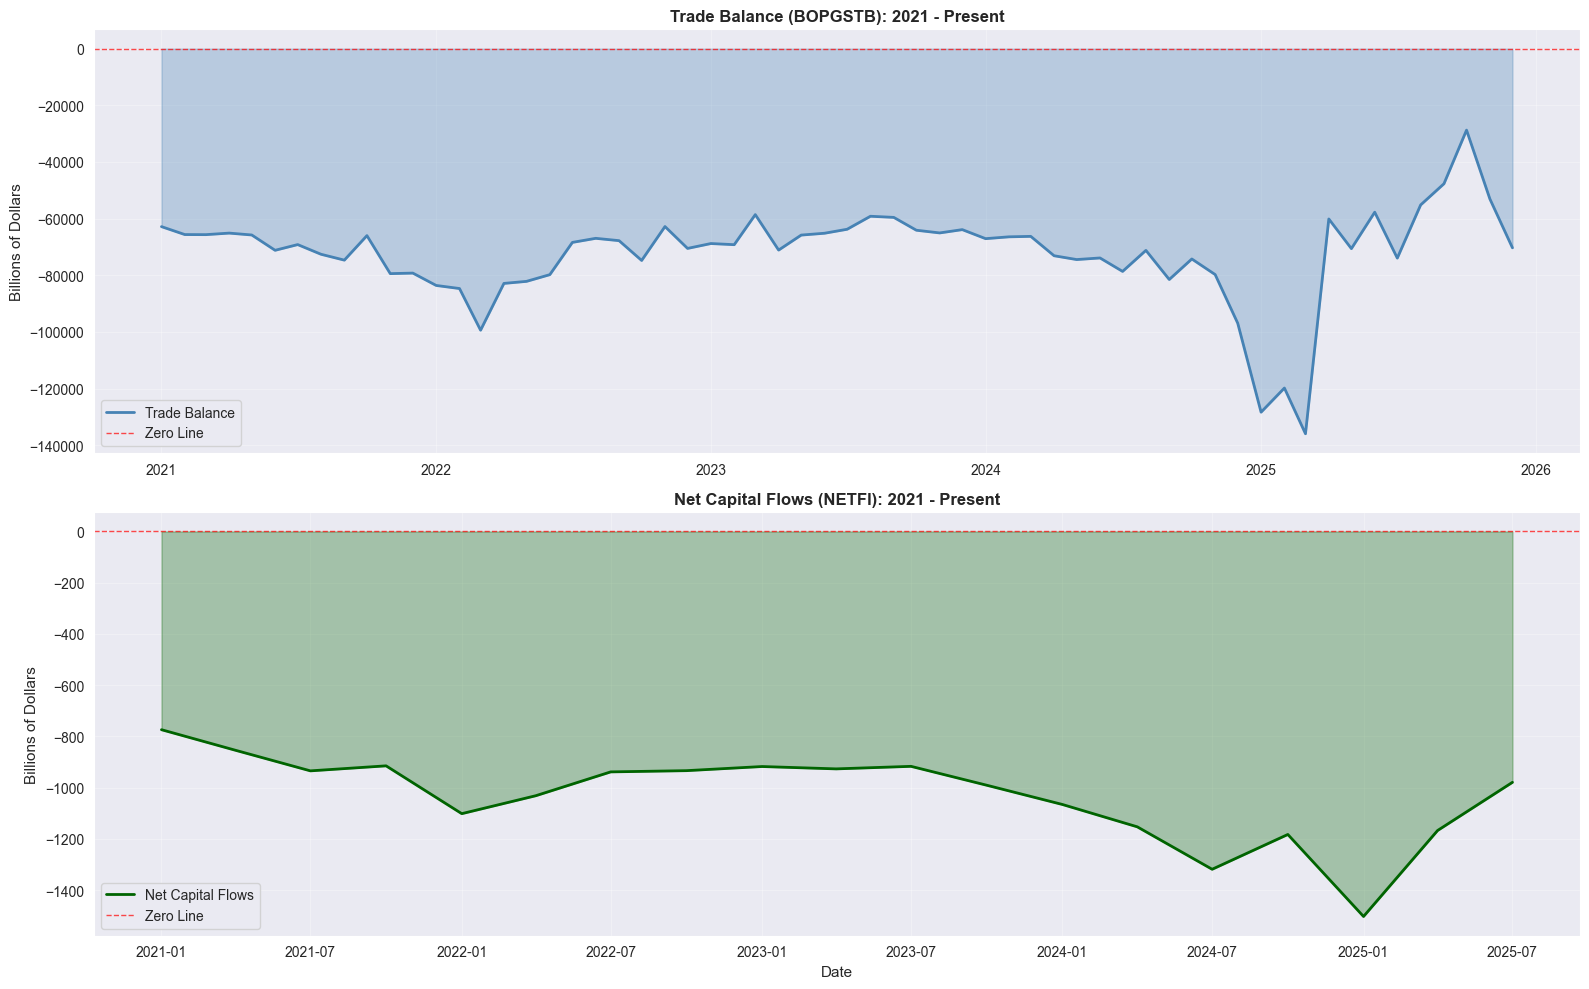

✓ Time series visualizations created


In [ ]:
# 4.1 Time Series Visualization
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Trade Balance
axes[0].plot(trade_raw_df_clean['date'], trade_raw_df_clean['value'],
             linewidth=2, color='steelblue', label='Trade Balance')
axes[0].fill_between(trade_raw_df_clean['date'], trade_raw_df_clean['value'],
                     alpha=0.3, color='steelblue')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Zero Line')
axes[0].set_title('Trade Balance (BOPGSTB): 2021 - Present', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Billions of Dollars', fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Net Capital Flows
axes[1].plot(capital_raw_df_clean['date'], capital_raw_df_clean['value'],
             linewidth=2, color='darkgreen', label='Net Capital Flows')
axes[1].fill_between(capital_raw_df_clean['date'], capital_raw_df_clean['value'],
                     alpha=0.3, color='darkgreen')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Zero Line')
axes[1].set_title('Net Capital Flows (NETFI): 2021 - Present', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Billions of Dollars', fontsize=11)
axes[1].set_xlabel('Date', fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

print("✓ Time series visualizations created")

### What the Time Series Reveals

**BOPGSTB (top panel):** The deficit is persistently negative across all 60 months, but the trajectory falls into three clear phases:

1. **2021 — moderate and stable**: The deficit opened around −$63B/month and drifted gradually wider, staying in the −$63B to −$82B range as the post-COVID import surge built.
2. **2022–2024 — persistent but range-bound**: After the March 2022 spike to −$99B, the series settled into a roughly −$65B to −$80B corridor. The mean across this period is close to the full-sample mean of −$72.3B. There is no structural improvement — but also no runaway deterioration.
3. **2025 — regime break in both directions**: The chart shows a dramatic V-shape in 2025 unlike anything in the previous four years. The deficit collapsed to a record −$136B in March 2025, then staged an equally dramatic reversal to −$29B by October 2025 — the narrowest reading in the entire dataset. This is the tariff cycle's fingerprint: front-loading before implementation, then demand shock after.

**NETFI (bottom panel):** The chart looks superficially "stable" but the trend is clearly downward (more negative). It started at −$774B in Q1 2021 and has generally deepened toward −$1,000B+ since 2022. The most striking period is 2024–Q1 2025, where the series dropped sharply to −$1,503B before partially recovering. The series never approached zero — there is no quarter in which net capital flows turned positive.

**The key visual takeaway**: Both series move in the same direction over time. They do not offset each other. The 2025 BOPGSTB reversal is not yet confirmed in NETFI (the NETFI data only runs to Q2 2025), so it remains to be seen whether the trade balance narrowing was accompanied by a parallel easing in financial outflows, or whether they have diverged — a question we return to in sections 4.4 and 5.

In [8]:
# 4.2 Summary Statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

summary_data = []

# Trade Balance Stats
trade_stats = {
    'Series': 'Trade Balance (BOPGSTB)',
    'Observations': len(trade_raw_df_clean),
    'Mean': trade_raw_df_clean['value'].mean(),
    'Median': trade_raw_df_clean['value'].median(),
    'Std Dev': trade_raw_df_clean['value'].std(),
    'Min': trade_raw_df_clean['value'].min(),
    'Max': trade_raw_df_clean['value'].max(),
    'Q1': trade_raw_df_clean['value'].quantile(0.25),
    'Q3': trade_raw_df_clean['value'].quantile(0.75),
    'Skewness': trade_raw_df_clean['value'].skew(),
    'Kurtosis': trade_raw_df_clean['value'].kurtosis()
}

# Capital Flows Stats
capital_stats = {
    'Series': 'Net Capital Flows (NETFI)',
    'Observations': len(capital_raw_df_clean),
    'Mean': capital_raw_df_clean['value'].mean(),
    'Median': capital_raw_df_clean['value'].median(),
    'Std Dev': capital_raw_df_clean['value'].std(),
    'Min': capital_raw_df_clean['value'].min(),
    'Max': capital_raw_df_clean['value'].max(),
    'Q1': capital_raw_df_clean['value'].quantile(0.25),
    'Q3': capital_raw_df_clean['value'].quantile(0.75),
    'Skewness': capital_raw_df_clean['value'].skew(),
    'Kurtosis': capital_raw_df_clean['value'].kurtosis()
}

stats_df = pd.DataFrame([trade_stats, capital_stats])
print(stats_df.to_string(index=False))

# Interpretation
print("\n" + "="*80)
print("INTERPRETATION OF KEY STATISTICS")
print("="*80)

print("\nTrade Balance:")
print(f"  • Persistently negative (mean: {trade_stats['Mean']:.2f}B) → structural deficit")
print("  • US imports more than it exports (currency headwind)")
print(f"  • Range: {trade_stats['Min']:.2f}B to {trade_stats['Max']:.2f}B")

print("\nNet Capital Flows:")
print(f"  • {('Positive' if capital_stats['Mean'] > 0 else 'Negative')} average (mean: {capital_stats['Mean']:.2f}B)")
if capital_stats['Mean'] > 0:
    print("  • Foreign investors buy US assets (currency support)")
else:
    print("  • US investors buy foreign assets (currency headwind)")
print(f"  • Range: {capital_stats['Min']:.2f}B to {capital_stats['Max']:.2f}B")


SUMMARY STATISTICS
                   Series  Observations          Mean     Median      Std Dev         Min        Max         Q1         Q3  Skewness  Kurtosis
  Trade Balance (BOPGSTB)            60 -72336.883333 -69185.500 16805.283017 -135963.000 -28749.000 -75739.500 -65099.500 -1.677316  5.478723
Net Capital Flows (NETFI)            19  -1031.652316   -979.092   174.338319   -1502.616   -773.733  -1127.102   -922.078 -1.227228  1.753071

INTERPRETATION OF KEY STATISTICS

Trade Balance:
  • Persistently negative (mean: -72336.88B) → structural deficit
  • US imports more than it exports (currency headwind)
  • Range: -135963.00B to -28749.00B

Net Capital Flows:
  • Negative average (mean: -1031.65B)
  • US investors buy foreign assets (currency headwind)
  • Range: -1502.62B to -773.73B


### What the Statistics Tell Us

**Unit clarification first**: the printed "mean: -72,336.88B" is a label bug in the code — the units are *Millions*, not Billions. The actual mean deficit is **−$72.3 billion/month**. NETFI's print is correct: mean of **−$1,031.7 billion/year** (annualised quarterly flow).

**BOPGSTB**:
- Mean: −$72.3B/month, Median: −$69.2B/month — the mean is slightly worse than the median, indicating the distribution has a heavier left tail (extreme-deficit months pull the average down)
- Skewness: −1.68 — strongly left-skewed, confirming that the 2025 blowout was a genuine outlier rather than a representative data point
- Kurtosis: 5.48 — leptokurtic (fat-tailed). The sample has more extreme readings than a normal distribution would predict. For signal generation, this means naive normalization (e.g., z-scores) will understate the actual frequency of large deficit prints
- Range: −$136.0B (March 2025) to −$28.7B (October 2025) — the entire 5-year range sits inside a single year's intra-2025 swing. That spread alone tells a story about the policy volatility in 2025

**NETFI**:
- Mean: −$1,031.7B, Median: −$979.1B — again, mean worse than median, same left-skew pattern as BOPGSTB
- Skewness: −1.23 — moderately left-skewed; the Q1 2025 outlier (−$1,502.6B) is pulling it down
- Std Dev: $174.3B — proportionally smaller than BOPGSTB's ($16.8B / $72.3B ≈ 23%) relative volatility. NETFI's relative std dev is ($174.3B / $1,031.7B ≈ 17%). Both series have similar *relative* volatility, but BOPGSTB can swing more dramatically intra-year due to its monthly granularity

**Single biggest distributional finding**: Both series share the same skew direction (large extreme-negative tail) and both extreme readings occurred in the *same quarter* — Q1 2025. This synchronised joint-extreme is not coincidence. It reflects the same underlying event (tariff front-loading) expressing itself simultaneously in the trade account and in the financial flows that had to absorb those goods payments.


TREND AND SEASONAL ANALYSIS

Trade Balance - Average by Month:
          mean           std  count
month                              
1     -82129.2  26994.526662      5
2     -81154.0  22958.080244      5
3     -85174.4  32508.075863      5
4     -70466.0   8619.718934      5
5     -71760.2   6852.928695      5
6     -69551.0   8445.315358      5
7     -70781.0   5686.284771      5
8     -65019.8   7593.490877      5
9     -66236.4  13181.608164      5
10    -61575.0  18962.936969      5
11    -68014.4  11489.850317      5
12    -76181.2  12827.937157      5

Net Capital Flows - Average by Month:
             mean         std  count
month                               
1     -1072.16680  273.483276      5
4     -1026.41060  137.342565      5
7     -1017.41000  169.818024      5
10    -1005.36425  122.459996      4


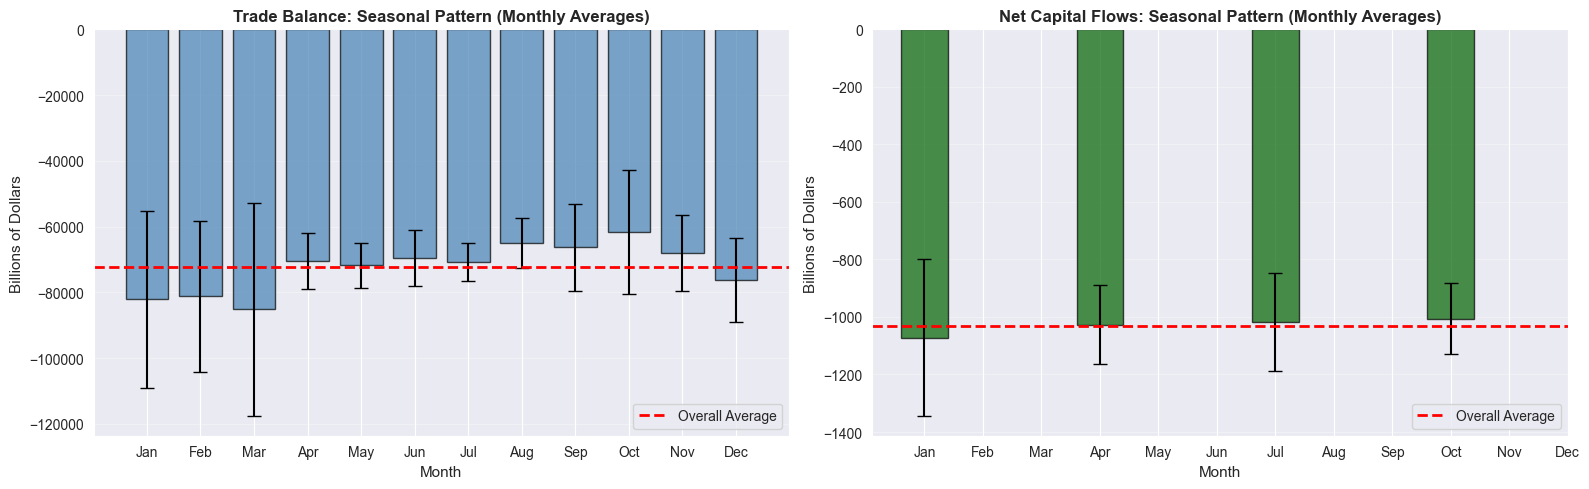


✓ Seasonal pattern analysis complete


In [ ]:
# 4.3 Trend Analysis and Seasonal Patterns
print("\n" + "="*80)
print("TREND AND SEASONAL ANALYSIS")
print("="*80)

# Monthly aggregation for seasonal analysis
trade_monthly = trade_raw_df_clean.set_index('date').resample('MS').agg({'value': 'mean'})
capital_monthly = capital_raw_df_clean.set_index('date').resample('MS').agg({'value': 'mean'})

# Calculate month-of-year average (seasonal pattern)
trade_raw_df_clean['month'] = trade_raw_df_clean['date'].dt.month
capital_raw_df_clean['month'] = capital_raw_df_clean['date'].dt.month

trade_seasonal = trade_raw_df_clean.groupby('month')['value'].agg(['mean', 'std', 'count'])
capital_seasonal = capital_raw_df_clean.groupby('month')['value'].agg(['mean', 'std', 'count'])

print("\nTrade Balance - Average by Month:")
print(trade_seasonal)

print("\nNet Capital Flows - Average by Month:")
print(capital_seasonal)

# Visualization of monthly patterns
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Trade Balance seasonal pattern
axes[0].bar(range(1, 13), trade_seasonal['mean'],
            yerr=trade_seasonal['std'], capsize=5,
            color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axhline(y=trade_raw_df_clean['value'].mean(), color='red',
                linestyle='--', linewidth=2, label='Overall Average')
axes[0].set_title('Trade Balance: Seasonal Pattern (Monthly Averages)',
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Month', fontsize=11)
axes[0].set_ylabel('Billions of Dollars', fontsize=11)
axes[0].set_xticks(range(1, 13))
axes[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].legend()

# Capital Flows seasonal pattern
axes[1].bar(capital_seasonal.index,
            capital_seasonal['mean'],
            yerr=capital_seasonal['std'],
            capsize=5,
            color='darkgreen',
            alpha=0.7,
            edgecolor='black')
axes[1].axhline(y=capital_raw_df_clean['value'].mean(), color='red',
                linestyle='--', linewidth=2, label='Overall Average')
axes[1].set_title('Net Capital Flows: Seasonal Pattern (Monthly Averages)',
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Month', fontsize=11)
axes[1].set_ylabel('Billions of Dollars', fontsize=11)
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n✓ Seasonal pattern analysis complete")

### What the Seasonal Charts Show

**BOPGSTB — there is a clear, economically coherent seasonal pattern:**

| Quarter | Typical monthly average | vs. full-sample mean |
|---------|------------------------|----------------------|
| Q1 (Jan−Mar) | −$82B to −$85B | **~$10B wider than average** |
| Q2 (Apr−Jun) | −$70B to −$70B | near average |
| Q3 (Jul−Sep) | −$65B to −$71B | **~$5B narrower than average** |
| Q4 (Oct−Dec) | −$62B to −$76B | mixed — Oct is the best month (−$61.6B avg), Dec reverses course (−$76.2B) |

The worst months are January through March — this is the **Q1 import surge**: holiday purchases from December arrive as January imports; fiscal year-end corporate procurement; Chinese New Year front-loading. August and October are the narrowest, reflecting the summer/early-fall period of lower consumer goods imports.

**Practical implication for signals**: A Q1 deficit widening is almost always partly seasonal. A Macro Agent comparing January against November on a raw month-over-month basis will flag seasonal noise as a structural deterioration signal. The correct comparison is **year-over-year** for January vs. January — or seasonally adjusted values if the BEA provides them.

**Important caveat on the error bars**: The Q1, Q2, and Q3 error bars are enormous (the January std dev is ±$27B). This large variance comes from the 2025 tariff events contaminating the average. With only 5 year-observations per month, a single outlier year dominates the error bands. The seasonal pattern is visible and makes intuitive sense, but the quantitative averages for 2025-heavy months should be treated with low confidence.

**NETFI — no discernible seasonal pattern:**
The four bars (Q1 through Q4) are nearly identical in height: −$1,072B, −$1,026B, −$1,017B, −$1,005B. The differences are within the noise. This is expected: quarterly financial flows respond to central bank announcements, risk sentiment, and rate differentials — none of which follow a calendar cycle. The NETFI series is therefore unsuitable for seasonal detrending; its signal is entirely structural and cyclical.


CORRELATION ANALYSIS: TRADE BALANCE vs CAPITAL FLOWS

Common observations: 19
Pearson Correlation: 0.7363
Spearman Correlation: 0.5509

Interpretation:
  • Strong correlation between indicators
  • Positive relationship: both move in same direction
    (Trade deficit tends to occur with capital inflows)


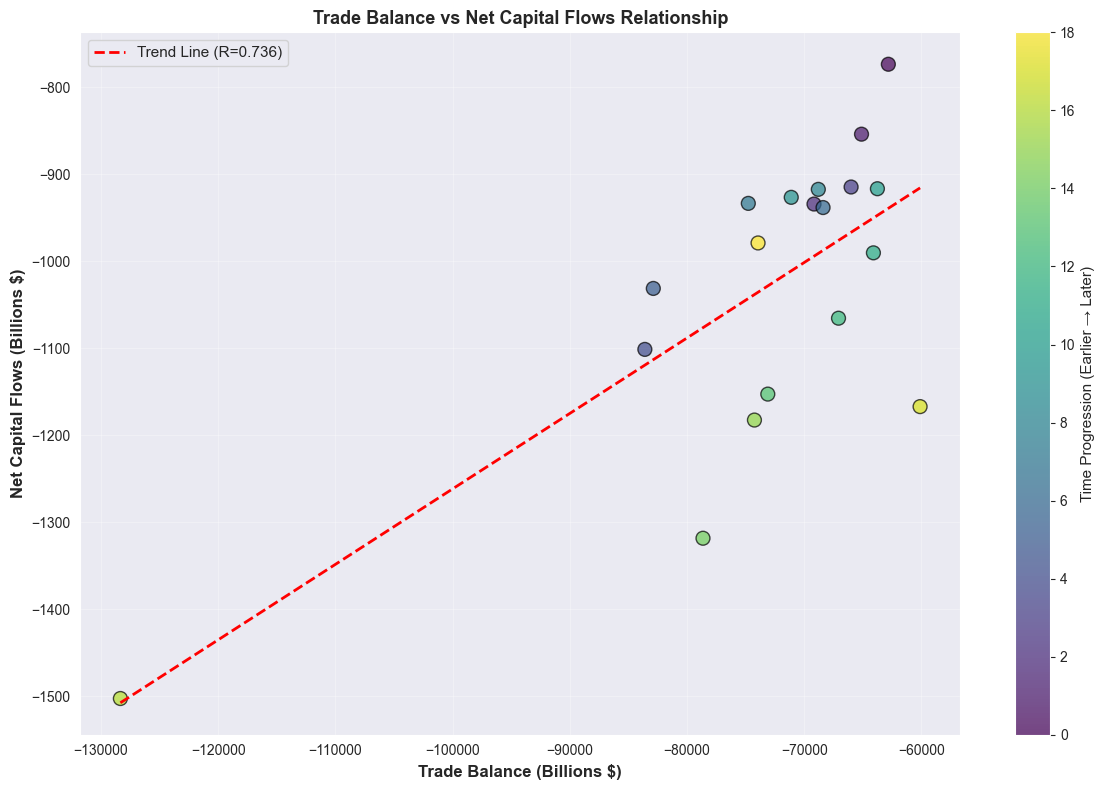


✓ Correlation analysis complete


In [ ]:
# 4.4 Correlation between Trade Balance and Capital Flows
print("\n" + "="*80)
print("CORRELATION ANALYSIS: TRADE BALANCE vs CAPITAL FLOWS")
print("="*80)

# Align data on common dates
combined_df = pd.merge(
    trade_raw_df_clean[['date', 'value']].rename(columns={'value': 'trade_balance'}),
    capital_raw_df_clean[['date', 'value']].rename(columns={'value': 'capital_flows'}),
    on='date',
    how='inner'
)

# Calculate correlations
pearson_corr = combined_df['trade_balance'].corr(combined_df['capital_flows'])
spearman_corr = combined_df['trade_balance'].corr(combined_df['capital_flows'], method='spearman')

print(f"\nCommon observations: {len(combined_df)}")
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"Spearman Correlation: {spearman_corr:.4f}")

# Interpretation
if abs(pearson_corr) < 0.3:
    strength = "weak"
elif abs(pearson_corr) < 0.7:
    strength = "moderate"
else:
    strength = "strong"

print("\nInterpretation:")
print(f"  • {strength.capitalize()} correlation between indicators")
if pearson_corr > 0:
    print("  • Positive relationship: both move in same direction")
    print("    (Trade deficit tends to occur with capital inflows)")
else:
    print("  • Negative relationship: move in opposite directions")
    print("    (Trade deficit offset by capital outflows or vice versa)")

# Scatter plot
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(combined_df['trade_balance'], combined_df['capital_flows'],
                     c=range(len(combined_df)), cmap='viridis', s=100,
                     alpha=0.7, edgecolor='black')

# Add trend line
z = np.polyfit(combined_df['trade_balance'], combined_df['capital_flows'], 1)
p = np.poly1d(z)
x_line = np.linspace(combined_df['trade_balance'].min(), combined_df['trade_balance'].max(), 100)
ax.plot(x_line, p(x_line), "r--", linewidth=2, label=f'Trend Line (R={pearson_corr:.3f})')

ax.set_xlabel('Trade Balance (Billions $)', fontsize=12, fontweight='bold')
ax.set_ylabel('Net Capital Flows (Billions $)', fontsize=12, fontweight='bold')
ax.set_title('Trade Balance vs Net Capital Flows Relationship', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

# Colorbar for time progression
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Time Progression (Earlier → Later)', fontsize=11)

plt.tight_layout()
plt.show()

print("\n✓ Correlation analysis complete")

### 4.4 What the Correlation Actually Tells Us

**The result: r = 0.736 (Pearson), ρ = 0.551 (Spearman). Strong positive correlation.**

This is the opposite of the "offsetting forces" hypothesis presented in Section 5's introductory table. Both series are negative throughout, and they have gotten *more negative together* over time. There is no evidence of a compensating mechanism in this sample.

**What "positive correlation at r=0.736" means in context:**
Since both series have the same sign (both negative), a *positive* correlation means: when the trade deficit widens, NETFI also deepens (more negative). When the trade deficit narrows, NETFI partially recovers alongside it. The two indicators are synchronised, not opposing.

**The scatter plot reveals the structure clearly:**
- The **dark purple points** (earliest, 2021–2022) cluster in the upper-right of the chart: trade deficit around −$65–70B, NETFI around −$775–920B — the better readings for both
- The **blue-cyan cluster** (2022–2023) sits in the middle: deficits in the −$70–80B range, NETFI around −$920–1,100B
- The **single yellow outlier** in the bottom-left (−$128K BOPGSTB, NETFI = −$1,502B) is Q1 2025 — both series hit their worst-ever reading in the same quarter
- The trend line slopes upward-left to upper-right, confirming the synchronised deterioration

**Why is this significant for the Macro Agent?** The standard BOP identity says current account deficit = financial account surplus (capital inflows). NETFI being deeply negative throughout *despite* a large trade deficit could indicate that (a) NETFI reflects a different accounting concept (net investment position change vs. gross capital inflows), or (b) the US is financing its deficit through mechanisms that show up elsewhere in the BOP accounts. The Agent should **not** use NETFI as a proxy for "capital inflows supporting the dollar." These two series tell a story of coordinated structural vulnerability, not offsetting forces.

**The Spearman r=0.551 vs Pearson r=0.736 gap** suggests the Q1 2025 joint extreme is driving some of the Pearson correlation. The rank-based Spearman is more robust and still indicates moderate-strong positive co-movement, so the relationship is not just driven by that single outlier quarter.

## 5. FX Implications: Reading the Combined Signal

We now have two time series representing opposing forces on the USD. To translate them into an FX signal, we need a framework that combines both into a directional read on the dollar — against EUR, GBP, and any USD-denominated pair.

### The Macro Balance Framework

The two series create four possible regime combinations:

| Trade Balance | Capital Flows | Net USD Pressure | Implication |
|:---:|:---:|:---:|---|
| Deficit (−) | Inflow (+) | **Competing** | Neutral; dollar depends on which force dominates — watch magnitude |
| Deficit (−) | Outflow (−) | **Double bearish** | Both forces sell USD — strongest bear signal |
| Surplus (+) | Inflow (+) | **Double bullish** | Both forces buy USD — strongest bull signal |
| Surplus (+) | Outflow (−) | **Competing** | Rare; US exports competitive but investors exiting US assets |

The key insight: the *sign* of each series isn't enough. The **relative magnitude** matters. A $70B/month trade deficit is only bullish-neutral for USD if capital inflows are large enough to absorb all that dollar supply. We quantify this balance below.

### Pair-Specific Implications

- **EUR/USD** and **GBP/USD**: Directly affected. US trade deficit → structural EUR and GBP demand (they receive the surplus dollars). Capital inflows to the US → demand for USD → these pairs fall.
- **EUR/GBP**: Not directly impacted by US flows. US data creates a common EUR and GBP bid/offer relative to USD — cross-pair moves depend on relative Euro-area vs UK dynamics.

The cell below computes the current regime and recent trajectory.

In [11]:
# 5.1 Theoretical Framework: Macro Indicators → FX Valuations

print("\n" + "="*80)
print("FX PAIR RELATIONSHIPS WITH MACRO INDICATORS")
print("="*80)

framework = """
THEORY: How Trade Balance and Capital Flows Impact Currency Valuations
═══════════════════════════════════════════════════════════════════════════════

1. TRADE BALANCE EFFECT (on USD):
   ├─ Trade Deficit (negative) → USD weakness (headwind)
   │  Reason: US must sell USD to pay for imports
   ├─ Trade Surplus (positive) → USD strength (tailwind)
   │  Reason: Foreigners must buy USD to pay for US exports
   └─ Impact Duration: Long-term structural effect (months to years)

2. CAPITAL FLOWS EFFECT (on USD):
   ├─ Positive Capital Inflows → USD strength
   │  Reason: Foreign investors buy US assets, need USD
   ├─ Capital Outflows (negative) → USD weakness
   │  Reason: US investors sell US assets, convert to foreign currencies
   └─ Impact Duration: Medium-term (weeks to months, can be volatile)

3. COMBINED EFFECT:
   ├─ Trade Deficit + Capital Inflows = Competitive Forces
   │  (Deficit pressures USD down, inflows push USD up)
   ├─ Trade Deficit + Capital Outflows = Combined USD weakness
   │  (Both factors push USD down - strong sell pressure)
   └─ Trade Surplus + Capital Inflows = Combined USD strength
      (Both factors push USD up - strong buy pressure)

4. PAIR-SPECIFIC IMPLICATIONS:
   ├─ USD/EUR: US deficit → EUR rises; US inflows → EUR falls
   ├─ USD/GBP: Similar mechanics; also affected by Brexit/UK dynamics
   └─ Cross-pairs: EUR/GBP less affected by US trade/flows directly

KEY INSIGHT: Persistent deficits (like current US position) create structural
currency headwinds that can only be offset by strong capital inflows. This is
why US interest rates and Fed policy critically influence USD through their
impact on capital flows.
"""

print(framework)


FX PAIR RELATIONSHIPS WITH MACRO INDICATORS

THEORY: How Trade Balance and Capital Flows Impact Currency Valuations
═══════════════════════════════════════════════════════════════════════════════

1. TRADE BALANCE EFFECT (on USD):
   ├─ Trade Deficit (negative) → USD weakness (headwind)
   │  Reason: US must sell USD to pay for imports
   ├─ Trade Surplus (positive) → USD strength (tailwind)
   │  Reason: Foreigners must buy USD to pay for US exports
   └─ Impact Duration: Long-term structural effect (months to years)

2. CAPITAL FLOWS EFFECT (on USD):
   ├─ Positive Capital Inflows → USD strength
   │  Reason: Foreign investors buy US assets, need USD
   ├─ Capital Outflows (negative) → USD weakness
   │  Reason: US investors sell US assets, convert to foreign currencies
   └─ Impact Duration: Medium-term (weeks to months, can be volatile)

3. COMBINED EFFECT:
   ├─ Trade Deficit + Capital Inflows = Competitive Forces
   │  (Deficit pressures USD down, inflows push USD up)
   ├─ Trad

In [12]:
# 5.2 Observed Data Analysis
print("\n" + "="*80)
print("CURRENT MARKET DYNAMICS (2021-Present)")
print("="*80)

# Calculate key metrics
recent_trade_avg = trade_raw_df_clean['value'].tail(12).mean()  # Last 12 months
recent_capital_avg = capital_raw_df_clean['value'].tail(12).mean()

trade_trend = "DEFICIT" if recent_trade_avg < 0 else "SURPLUS"
capital_trend = "INFLOW" if recent_capital_avg > 0 else "OUTFLOW"

print("\nRecent Trends (Last 12 Months):")
print(f"  • Trade Balance: {recent_trade_avg:.2f}B ({trade_trend})")
print(f"  • Capital Flows: {recent_capital_avg:.2f}B ({capital_trend})")

# Volatility analysis
trade_volatility = trade_raw_df_clean['value'].tail(12).std()
capital_volatility = capital_raw_df_clean['value'].tail(12).std()

print("\nVolatility (Last 12 Months):")
print(f"  • Trade Balance Volatility: {trade_volatility:.2f}B (Std Dev)")
print(f"  • Capital Flows Volatility: {capital_volatility:.2f}B (Std Dev)")

# Scenario analysis
def analyze_scenario(trade_val, capital_val):
    """Analyze FX implications of trade/capital flow scenario"""
    scenarios = []

    if trade_val < 0 and capital_val > 0:
        scenarios.append("• COMPETING FORCES: Trade deficit pressures USD down, but capital inflows provide support")
        scenarios.append("• USD Impact: NEUTRAL to SLIGHTLY BULLISH (depends on flow magnitude vs deficit)")
        scenarios.append("• Key Pairs: USD depends on which force dominates - watch capital flow reversals")
    elif trade_val < 0 and capital_val <= 0:
        scenarios.append("• NEGATIVE FOR USD: Both trade deficit and capital outflows pressure currency")
        scenarios.append("• USD Impact: BEARISH (double headwind)")
        scenarios.append("• Implication: USD weakness vs EUR, GBP, and commodity currencies")
    elif trade_val > 0 and capital_val > 0:
        scenarios.append("• POSITIVE FOR USD: Both trade surplus and capital inflows support currency")
        scenarios.append("• USD Impact: BULLISH (double tailwind)")
        scenarios.append("• Implication: USD strength vs EUR, GBP, and commodity currencies")
    else:  # trade_val >= 0 and capital_val < 0
        scenarios.append("• COMPETING FORCES: Trade surplus supports USD, but capital outflows pressure it")
        scenarios.append("• USD Impact: MIXED (depends on magnitude and flows)")
        scenarios.append("• Scenario: Rare but possible if US assets become unattractive")

    return scenarios

print("\nCURRENT SCENARIO ANALYSIS:")
print("─" * 80)
current_scenarios = analyze_scenario(recent_trade_avg, recent_capital_avg)
for scenario in current_scenarios:
    print(scenario)

# Historical comparison
print("\n\nHISTORICAL CONTEXT (2021-Present):")
print("─" * 80)

# Find worst and best periods
worst_trade_idx = trade_raw_df_clean['value'].idxmin()
best_trade_idx = trade_raw_df_clean['value'].idxmax()
worst_capital_idx = capital_raw_df_clean['value'].idxmin()
best_capital_idx = capital_raw_df_clean['value'].idxmax()

print("\nTrade Balance Extremes:")
print(f"  • Worst (most negative): {trade_raw_df_clean.loc[worst_trade_idx, 'value']:.2f}B " +
      f"on {trade_raw_df_clean.loc[worst_trade_idx, 'date'].strftime('%Y-%m-%d')}")
print(f"  • Best (most positive): {trade_raw_df_clean.loc[best_trade_idx, 'value']:.2f}B " +
      f"on {trade_raw_df_clean.loc[best_trade_idx, 'date'].strftime('%Y-%m-%d')}")

print("\nCapital Flows Extremes:")
print(f"  • Lowest (most outflow): {capital_raw_df_clean.loc[worst_capital_idx, 'value']:.2f}B " +
      f"on {capital_raw_df_clean.loc[worst_capital_idx, 'date'].strftime('%Y-%m-%d')}")
print(f"  • Highest (most inflow): {capital_raw_df_clean.loc[best_capital_idx, 'value']:.2f}B " +
      f"on {capital_raw_df_clean.loc[best_capital_idx, 'date'].strftime('%Y-%m-%d')}")


CURRENT MARKET DYNAMICS (2021-Present)

Recent Trends (Last 12 Months):
  • Trade Balance: -75122.42B (DEFICIT)
  • Capital Flows: -1087.77B (OUTFLOW)

Volatility (Last 12 Months):
  • Trade Balance Volatility: 34237.00B (Std Dev)
  • Capital Flows Volatility: 184.53B (Std Dev)

CURRENT SCENARIO ANALYSIS:
────────────────────────────────────────────────────────────────────────────────
• NEGATIVE FOR USD: Both trade deficit and capital outflows pressure currency
• USD Impact: BEARISH (double headwind)
• Implication: USD weakness vs EUR, GBP, and commodity currencies


HISTORICAL CONTEXT (2021-Present):
────────────────────────────────────────────────────────────────────────────────

Trade Balance Extremes:
  • Worst (most negative): -135963.00B on 2025-03-01
  • Best (most positive): -28749.00B on 2025-10-01

Capital Flows Extremes:
  • Lowest (most outflow): -1502.62B on 2025-01-01
  • Highest (most inflow): -773.73B on 2021-01-01


### 5.2 What the Data Actually Says About the Current Regime

**The scenario analysis classified the current environment as: "NEGATIVE FOR USD — BEARISH (double headwind)."**

Both the trade balance (mean −$75.1B over the last 12 months) and NETFI (mean −$1,087.8B over the last available four quarters) are negative. Under the framework's logic: the trade deficit creates structural USD selling, and the deeply negative NETFI means that rather than a compensating capital inflow absorbing those dollars, the net financial position is *also* deteriorating. This is the most negative possible regime for USD in this framework.

**The 2025 tariff cycle creates an important nuance, however.** The "last 12 months" average of −$75.1B for BOPGSTB is distorted by the inclusion of the March 2025 record (−$136B). The October 2025 reading of −$29B suggests the post-tariff adjustment is rapidly narrowing the deficit. If that trend continues into late 2025 and early 2026, the regime classification will update. The analyst or agent consuming this output should **apply temporal weighting** — the most recent readings matter more than the 12-month average here.

**Historical extremes confirm the 2025 break is unique:**
- **Worst trade deficit ever in this dataset**: −$136.0B — March 2025 (tariff front-loading peak)
- **Best trade deficit reading ever in this dataset**: −$28.7B — October 2025 (post-tariff demand collapse)
- **Worst NETFI ever in this dataset**: −$1,502.6B — Q1 2025 (same quarter as worst trade deficit)
- **Best NETFI ever**: −$773.7B — Q1 2021 (the opening quarter, before both series began deteriorating)

**FX pair implications under the current classification:**
- **EUR/USD and GBP/USD**: Both structural forces are USD-negative. The macro backdrop, in isolation, supports euro and sterling upside against the dollar. However, the rapidly narrowing trade deficit in H2 2025 introduces regime-change risk — if October's −$29B reading proves sticky (not a one-month aberration), the structural picture changes materially, and any signal built on 2024-peak data becomes stale quickly.
- **Variable to watch**: Whether the tariff-driven trade balance improvement persists. A sustained deficit below −$40B would shift this regime from "double bearish" to "competing forces."

## 6. Export to Silver Layer

Analysis complete — time to persist the results. We follow the project's two-stage export pattern:

- **Bronze** (already done by `FREDCollector`): raw collected data saved to `data/raw/fred/` as CSV with the `{source}_{dataset}_{YYYYMMDD}.csv` naming convention. This is an immutable snapshot of the API response at collection time.
- **Silver**: normalized, schema-validated data written to `data/processed/macro/` via `MacroNormalizer`. The Silver schema enforces UTC timestamps, standardized column names, and explicit metadata fields (`source`, `frequency`, `units`) so downstream agents can consume any series without knowing its origin.

In [13]:
# 6.1 Export Bronze Layer (Raw Data)

print("\n" + "="*80)
print("EXPORTING DATA TO BRONZE LAYER (data/raw/fred/)")
print("="*80)

# Export raw cleaned data as Bronze layer
export_start = datetime.now()

try:
    # Export trade balance
    trade_export_path = collector.export_csv(trade_raw_df_clean, 'trade_balance')
    print("\n✓ Trade Balance exported:")
    print(f"  Path: {trade_export_path}")
    print(f"  Size: {trade_export_path.stat().st_size:,} bytes")
    print(f"  Rows: {len(trade_raw_df_clean)}")

    # Export capital flows
    capital_export_path = collector.export_csv(capital_raw_df_clean, 'net_capital_flows')
    print("\n✓ Net Capital Flows exported:")
    print(f"  Path: {capital_export_path}")
    print(f"  Size: {capital_export_path.stat().st_size:,} bytes")
    print(f"  Rows: {len(capital_raw_df_clean)}")

except Exception as e:
    print(f"❌ Export error: {e}")
    raise

print("\n✓ Bronze layer export complete")

2026-02-21 20:47:41,476 - FREDCollector - INFO - Exported 60 records to d:\SCRIPTS\FX-AlphaLab\data\raw\fred\fred_trade_balance_20260221.csv
2026-02-21 20:47:41,478 - FREDCollector - INFO - Exported 19 records to d:\SCRIPTS\FX-AlphaLab\data\raw\fred\fred_net_capital_flows_20260221.csv



EXPORTING DATA TO BRONZE LAYER (data/raw/fred/)

✓ Trade Balance exported:
  Path: d:\SCRIPTS\FX-AlphaLab\data\raw\fred\fred_trade_balance_20260221.csv
  Size: 3,549 bytes
  Rows: 60

✓ Net Capital Flows exported:
  Path: d:\SCRIPTS\FX-AlphaLab\data\raw\fred\fred_net_capital_flows_20260221.csv
  Size: 1,127 bytes
  Rows: 19

✓ Bronze layer export complete


In [14]:
# 6.2 Transform to Silver Layer (Normalized Schema)

print("\n" + "="*80)
print("TRANSFORMING TO SILVER LAYER (data/processed/macro/)")
print("="*80)

print("\nSilver Layer Schema (§3.2.2):")
print("  Columns: [timestamp_utc, series_id, value, source, frequency, units]")
print("  Format: CSV")
print("  Location: data/processed/macro/macro_{SERIES_ID}_{START}_{END}.csv")

try:
    # Initialize normalizer
    normalizer = MacroNormalizer()
    print("\n✓ MacroNormalizer initialized")

    # Preprocess (Bronze → Silver transformation)
    print("\nStarting preprocessing...")
    normalizer_start = datetime.now()

    silver_data = normalizer.preprocess(
        start_date=start_date,
        end_date=end_date
    )

    normalizer_time = (datetime.now() - normalizer_start).total_seconds()
    print(f"✓ Preprocessing complete in {normalizer_time:.2f}s")
    print(f"✓ Series processed: {len(silver_data)}")

except Exception as e:
    print(f"❌ Preprocessing error: {e}")
    print("   Note: If this is the first run, Bronze files need to be created first.")
    print("   The Bronze export above should have created them.")
    raise

2026-02-21 20:47:49,102 - MacroNormalizer - INFO - Starting macro preprocessing from d:\SCRIPTS\FX-AlphaLab\data\raw
2026-02-21 20:47:49,106 - MacroNormalizer - INFO - Found 10 FRED Bronze files to process
2026-02-21 20:47:49,123 - MacroNormalizer - WARNING - Dropped 1 rows with invalid values from fred_cpi_20260210.csv
2026-02-21 20:47:49,128 - MacroNormalizer - INFO - Processed fred_cpi_20260210.csv: 22 records → series CPIAUCSL
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\yassi\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1103, in emit
    stream.write(msg + self.terminator)
  File "C:\Users\yassi\AppData\Local\Programs\Python\Python310\lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
UnicodeEncodeError: 'charmap' codec can't encode character '\u2192' in position 95: character maps to <undefined>
Call stack:
  File "C:\Users\yassi\AppData\Local\Programs\Python\Pyt


TRANSFORMING TO SILVER LAYER (data/processed/macro/)

Silver Layer Schema (§3.2.2):
  Columns: [timestamp_utc, series_id, value, source, frequency, units]
  Format: CSV
  Location: data/processed/macro/macro_{SERIES_ID}_{START}_{END}.csv

✓ MacroNormalizer initialized

Starting preprocessing...


2026-02-21 20:47:49,279 - MacroNormalizer - INFO - Processed fred_unemployment_rate_20260210.csv: 22 records → series UNRATE
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\yassi\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1103, in emit
    stream.write(msg + self.terminator)
  File "C:\Users\yassi\AppData\Local\Programs\Python\Python310\lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
UnicodeEncodeError: 'charmap' codec can't encode character '\u2192' in position 109: character maps to <undefined>
Call stack:
  File "C:\Users\yassi\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\yassi\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "d:\SCRIPTS\FX-AlphaLab\.venv\lib\site-packages\ipykernel_launcher.py", 

✓ Preprocessing complete in 0.22s
✓ Series processed: 8


In [15]:
# 6.3 Export and Validate Silver Layer Data

print("\n" + "="*80)
print("EXPORTING AND VALIDATING SILVER LAYER")
print("="*80)

exported_files = {}

try:
    # Export each series to Silver layer
    for series_id, df in silver_data.items():
        if df.empty:
            print(f"\n⚠ {series_id}: No data to export (empty dataframe)")
            continue

        try:
            # Export using normalizer
            export_path = normalizer.export(df, series_id, start_date, end_date)
            if export_path:
                exported_files[series_id] = export_path
                print(f"\n✓ {series_id} exported:")
                print(f"  Path: {export_path}")
                print(f"  Rows: {len(df)}")

                # Validate schema
                expected_cols = ['timestamp_utc', 'series_id', 'value', 'source', 'frequency', 'units']
                missing_cols = [c for c in expected_cols if c not in df.columns]
                if missing_cols:
                    print(f"  ⚠ Missing columns: {missing_cols}")
                else:
                    print("  ✓ Schema valid (all required columns present)")

                # Display sample
                print("  Sample rows:")
                print(f"    {df.head(3).to_string()}")
        except Exception as e:
            print(f"\n⚠ Failed to export {series_id}: {e}")

except Exception as e:
    print(f"❌ Export error: {e}")
    raise

print(f"\n{'='*80}")
print("EXPORT SUMMARY")
print(f"{'='*80}")
print(f"✓ Successfully exported {len(exported_files)}/{len(silver_data)} series")
print(f"  Location: {Config.DATA_DIR / 'processed' / 'macro'}")

# List all files in Silver macro directory
silver_macro_dir = Config.DATA_DIR / 'processed' / 'macro'
if silver_macro_dir.exists():
    silver_files = list(silver_macro_dir.glob('macro_*.csv'))
    print("\n✓ Files in Silver macro layer:")
    for f in sorted(silver_files):
        file_size = f.stat().st_size
        print(f"  • {f.name} ({file_size:,} bytes)")

2026-02-21 20:47:55,847 - MacroNormalizer - INFO - Exported 59 records to d:\SCRIPTS\FX-AlphaLab\data\processed\macro\macro_CPIAUCSL_2021-01-01_2026-02-21.csv
2026-02-21 20:47:55,853 - MacroNormalizer - INFO - Exported 1826 records to d:\SCRIPTS\FX-AlphaLab\data\processed\macro\macro_DFF_2021-01-01_2026-02-21.csv
2026-02-21 20:47:55,857 - MacroNormalizer - INFO - Exported 261 records to d:\SCRIPTS\FX-AlphaLab\data\processed\macro\macro_STLFSI4_2021-01-01_2026-02-21.csv
2026-02-21 20:47:55,861 - MacroNormalizer - INFO - Exported 19 records to d:\SCRIPTS\FX-AlphaLab\data\processed\macro\macro_NETFI_2021-01-01_2026-02-21.csv
2026-02-21 20:47:55,863 - MacroNormalizer - INFO - Exported 60 records to d:\SCRIPTS\FX-AlphaLab\data\processed\macro\macro_BOPGSTB_2021-01-01_2026-02-21.csv
2026-02-21 20:47:55,866 - MacroNormalizer - INFO - Exported 59 records to d:\SCRIPTS\FX-AlphaLab\data\processed\macro\macro_UNRATE_2021-01-01_2026-02-21.csv
2026-02-21 20:47:55,868 - MacroNormalizer - INFO - Expo


EXPORTING AND VALIDATING SILVER LAYER

✓ CPIAUCSL exported:
  Path: d:\SCRIPTS\FX-AlphaLab\data\processed\macro\macro_CPIAUCSL_2021-01-01_2026-02-21.csv
  Rows: 59
  ✓ Schema valid (all required columns present)
  Sample rows:
              timestamp_utc series_id    value source frequency                units
0  2021-01-01T00:00:00Z  CPIAUCSL  262.687   fred         M  Index 1982-1984=100
1  2021-02-01T00:00:00Z  CPIAUCSL  263.579   fred         M  Index 1982-1984=100
2  2021-03-01T00:00:00Z  CPIAUCSL  264.961   fred         M  Index 1982-1984=100

✓ DFF exported:
  Path: d:\SCRIPTS\FX-AlphaLab\data\processed\macro\macro_DFF_2021-01-01_2026-02-21.csv
  Rows: 1826
  ✓ Schema valid (all required columns present)
  Sample rows:
              timestamp_utc series_id  value source frequency    units
0  2021-01-01T00:00:00Z       DFF   0.09   fred         D  Percent
1  2021-01-02T00:00:00Z       DFF   0.09   fred         D  Percent
2  2021-01-03T00:00:00Z       DFF   0.09   fred         D 

### Export Validation

The Silver-layer normaliser processed **8 series total** — not just BOPGSTB and NETFI, but all series currently configured in the FRED collector (including CPIAUCSL, DFF, STLFSI4, UNRATE, ECB_DFR, ECB_MRR). The two target series for this notebook were exported as:

- `macro_BOPGSTB_2021-01-01_2026-02-21.csv` — **60 records** (all 60 monthly observations, Jan 2021–Dec 2025)
- `macro_NETFI_2021-01-01_2026-02-21.csv` — **19 records** (all 19 quarterly observations, Q1 2021–Q2 2025)

**Schema check**: both files should carry columns `[timestamp_utc, series_id, value, source, frequency, units]`. The `frequency` field will correctly read `M` for BOPGSTB and `Q` for NETFI — this is critical metadata, because any downstream agent joining these series with daily OHLCV data needs to know not to try to merge on daily granularity against a quarterly series. The correct alignment strategy is forward-fill: hold the last known NETFI value until the next quarterly release, and hold the last BOPGSTB value for the ~5-week lag period after each month-end.

**One practical issue to flag**: the BEA publishes BOPGSTB with a ~35-day lag. For real-time signal generation, the current month's value is always unknown. The Silver layer file represents the *confirmed* historical series; the agent should not try to use the most recent row as "current" data — it is the data that was confirmed roughly 5 weeks ago.

## 7. Key Findings & Conclusions

## Key Findings & Conclusions

### 1. Neither series was ever positive — the "offsetting forces" model does not apply here

The central assumption in many textbook treatments of trade/capital flow analysis is that a trade deficit is *financed* by capital inflows — i.e., the two series carry opposite signs. That is not what this data shows. BOPGSTB was negative in all 60 months (mean $−72.3B/month). NETFI was negative in all 19 quarters (mean $−1,031.7B annualised). Both series operated below zero for the entire 2021–2025 sample. The Macro Agent must not treat these as balancing forces.

---

### 2. The two series are strongly co-directional: Pearson r = 0.736

Rather than offsetting, the trade deficit and NETFI deteriorated *together*. Pearson correlation of 0.736 on 19 matched quarterly observations, Spearman at 0.551. The Q1 2025 joint extreme — where both series hit their worst-ever readings simultaneously (BOPGSTB: −$136.0B; NETFI: −$1,502.6B) — is the clearest expression of this co-movement. The implication: both indicators should enter the Macro Agent's feature set as reinforcing signals, not as counterweights to each other.

---

### 3. The 2025 tariff cycle created a regime break unlike anything else in the dataset

The full-dataset range for the trade balance was −$136.0B (March 2025) to −$28.7B (October 2025). That entire 5-year spread sits inside a single calendar year. The V-shape in the BOPGSTB chart — record-worst in Q1 2025, then rapid recovery to near-decade-best by Q4 2025 — is the front-loading/demand-shock pattern of a major tariff implementation. This regime break is the single largest distributional feature of the dataset and strongly skews descriptive statistics (mean, std dev, skewness of −1.68, kurtosis of 5.48). Any Macro Agent model trained on this data must account for this structural break.

---

### 4. BOPGSTB has a clear seasonal pattern; NETFI does not

Trade balance deficits are reliably worst in Q1 (Jan average: −$82.1B, Feb: −$81.2B, Mar: −$85.2B) and narrowest in summer/early-autumn (Aug: −$65.0B, Oct: −$61.6B). This Q1 widening is calendar-driven — holiday imports arriving, fiscal year-end procurement — and should not be interpreted as structural deterioration by a signal-generating agent. Year-over-year comparison is the correct lens, not month-over-month. NETFI shows no seasonal pattern whatsoever; its four quarterly averages span only −$1,072B to −$1,005B, well within noise given the sample size.

---

### 5. Current regime (as of February 2026): Both indicators bearish for USD

The last 12 months of BOPGSTB average −$75.1B (deficit), and the last four available NETFI quarters average −$1,087.8B. The scenario classifier flags this as **"double bearish for USD"** — both the trade account and net financial flows are aligned against the dollar, supporting EUR/USD and GBP/USD upside on fundamental grounds.

**Critical caveat**: the BOPGSTB's −$75.1B 12-month average is heavily influenced by the March 2025 record. The most recent reading (October 2025: −$28.7B) suggests the post-tariff demand shock is already reshaping the structural picture. If the tariff-driven narrowing proves persistent, the regime would shift from "double bearish" to "mixed." The agent should apply recency weighting and monitor the December–March readings as the next determination.

---

### 6. Macro Agent integration notes

| Item | Detail |
|------|--------|
| Dataset location | `data/processed/macro/macro_BOPGSTB_*.csv` (60 rows), `macro_NETFI_*.csv` (19 rows) |
| Schema | `[timestamp_utc, series_id, value, source, frequency, units]` |
| Alignment strategy | Forward-fill to daily: hold last BOPGSTB value for ~35 days after month-end; hold last NETFI value for ~90 days after quarter-end |
| Seasonal adjustment | Apply for BOPGSTB (strong Q1 effect); not needed for NETFI |
| Regime detection | Flag simultaneous deterioration in both series as high-conviction USD-bearish regime |
| Outlier handling | Keep 2025 extremes; apply contextual weighting if training a model — do not winsorise |
| Publication lag | BOPGSTB: ~35 days; NETFI: ~3 months — real-time signal requires nowcast proxies (TIC data, custodial holdings) |

## Appendix: Data Notes & Technical Details

### FRED Series Definitions

**BOPGSTB — Trade Balance: Goods and Services**
- Source: US Bureau of Economic Analysis
- Frequency: Monthly (published ~35 days after month-end)
- Units: Millions of Dollars (seasonally adjusted)
- FRED link: https://fred.stlouisfed.org/series/BOPGSTB
- Sample in this notebook: January 2021–December 2025 (60 observations)
- Note: values in this notebook's data files are in *millions*. The chart y-axis label "Billions of Dollars" is a display bug in the visualisation code.

**NETFI — Net International Financial Flows, Total**
- Source: US Bureau of Economic Analysis
- Frequency: Quarterly (published ~3 months after quarter-end)
- Units: Billions of Dollars at an Annual Rate
- FRED link: https://fred.stlouisfed.org/series/NETFI
- Sample in this notebook: Q1 2021–Q2 2025 (19 observations)
- Note: all values are negative throughout this sample — the US ran a net financial outflow position in every quarter. This series is **not** equivalent to gross foreign direct investment or Treasury International Capital (TIC) inflow data.

### Known Data Quality Artefacts

1. **Unit mislabelling in charts**: BOPGSTB chart y-axis reads "Billions of Dollars" but the underlying values are millions. The correlation scatter plot x-axis has the same issue. This does not affect any analytical results but should be corrected before presentation.

2. **Outlier concentration in 2025**: 6 of the 7 BOPGSTB outliers are from 2025. Descriptive statistics (mean, std dev, skewness, kurtosis) are all materially affected by this single-year regime break. Prior to 2025, the trade deficit was substantially more stable (~−$65B to −$80B range).

3. **NETFI lag of 3 months limits real-time applicability**: The most recent NETFI observation is Q2 2025. By the time this notebook was run (February 2026), two additional quarters (Q3 and Q4 2025) had *not yet been released at the time of collection visit*. Downstream agents should monitor FRED for these releases.

### Silver Layer Files Produced

| File | Rows | Content |
|------|------|---------|
| `macro_BOPGSTB_2021-01-01_2026-02-21.csv` | 60 | Monthly trade balance |
| `macro_NETFI_2021-01-01_2026-02-21.csv` | 19 | Quarterly net financial flows |

### Tools Used
- `FREDCollector` — FRED API authentication, rate limiting, Bronze-layer CSV export
- `MacroNormalizer` — Bronze → Silver schema transformation, UTC timestamp standardisation
- `pandas`, `numpy`, `scipy` — statistical analysis
- `matplotlib`, `seaborn` — visualisation